In [52]:
import sys
import os
import grid2op
from lightsim2grid import LightSimBackend
import inspect
import pdb
import numpy as np
import pandas as pd
from grid2op.Reward import GameplayReward

# from grid2op.gym_compat import GymEnv
# from l2rpn_baselines.utils import GymEnvWithRecoWithDN, GymEnvWithHeuristics
# from grid2op.Chronics.multiFolder import Multifolder
# from GymEnvStorage import GymEnvStorage
from GymEnvWithSetPoint import GymEnvWithSetPoint
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace
from utils import get_env_seed

# from grid2op.Observation import BaseObservation
# from typing import Tuple, Dict

# from l2rpn_baselines.utils import GymAgent
from tqdm import tqdm
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import json

In [53]:
env = grid2op.make("educ_case14_storage_custom",
                    backend=LightSimBackend(),
                    reward_class=GameplayReward,
                    )
obs = env.reset()
obs, reward, done, info = env.step(env.action_space())
reward, info

(1.0,
 {'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1], dtype=int32),
  'is_illegal': False,
  'is_ambiguous': False,
  'is_dispatching_illegal': False,
  'is_illegal_reco': False,
  'reason_alarm_illegal': None,
  'opponent_attack_line': None,
  'opponent_attack_sub': None,
  'opponent_attack_duration': 0,
  'exception': [],
  'rewards': {}})

In [54]:
from l2rpn_baselines.PPO_SB3.utils import SB3Agent
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace
from GymEnvWithRecoWithDNWithShuffle import GymEnvWithRecoWithDNWithShuffle
from run_trained_agents import BaselineAgent
from stable_baselines3 import PPO

def get_agent(weights_dir, env, safe_max_rho=0.2, limit_cs_margin=-1):
    """this is basically a copy paste of the PPO_SB3 evaluate function with some minor modification
    used to load the correct weights
    """
    agent_dir = os.path.dirname(weights_dir)
    submission_dir = os.path.dirname(agent_dir)

    # compute the score of said agent
    with open(os.path.join(submission_dir, "preprocess_obs.json"), 'r', encoding="utf-8") as f:
        obs_space_kwargs = json.load(f)
    obs_space_kwargs["functs"] = {"storage_capacity_setpoint":
                                        (lambda grid2op_obs: np.full(env.n_storage, env.parameters.INIT_STORAGE_CAPACITY), 0., 1.0, None, None)}
    with open(os.path.join(submission_dir, "preprocess_act.json"), 'r', encoding="utf-8") as f:
        act_space_kwargs = json.load(f)
    
    # load the attributes kept
    with open(os.path.join(agent_dir, "obs_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
        obs_attr_to_keep = json.load(fp=f)
    with open(os.path.join(agent_dir, "act_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
        act_attr_to_keep = json.load(fp=f)

    # load gym env kwargs especially alpha
    with open(os.path.join(agent_dir, "dict_train_args.json"), encoding="utf-8", mode="r") as f:
        dict_train_args = json.load(fp=f)
    gymenv_kwargs = dict_train_args["gymenv_kwargs"]
    gymenv_kwargs.pop("safe_max_rho", None)

    # create the action and observation space
    gym_observation_space =  BoxGymObsSpace(env.observation_space,
                                            attr_to_keep=obs_attr_to_keep,
                                            **obs_space_kwargs)
    gym_action_space = BoxGymActSpace(env.action_space,
                                      attr_to_keep=act_attr_to_keep,
                                      **act_space_kwargs)

    # apply normalization on created gym_observation_space and gym_action_space
    for attr_nm in act_attr_to_keep:
            if (("multiply" in act_space_kwargs and attr_nm in act_space_kwargs["multiply"]) or 
                ("add" in act_space_kwargs and attr_nm in act_space_kwargs["add"]) 
               ):
                # attribute is scaled elsewhere
                continue
            gym_action_space.normalize_attr(attr_nm)
    
    for attr_nm in obs_attr_to_keep:
            if (("divide" in obs_space_kwargs and attr_nm in obs_space_kwargs["divide"]) or 
                ("subtract" in obs_space_kwargs and attr_nm in obs_space_kwargs["subtract"]) 
               ):
                # attribute is scaled elsewhere
                continue
            gym_observation_space.normalize_attr(attr_nm)
    
    # create the gym environment for the PPO agent...
    gymenv = GymEnvWithSetPoint(env, safe_max_rho=float(safe_max_rho), shuffle_chronics=False, **gymenv_kwargs)    
    gymenv.action_space.close()
    gymenv.action_space = gym_action_space
    gymenv.observation_space.close()
    gymenv.observation_space = gym_observation_space
    
    # create a grid2gop agent based on that (this will reload the save weights)
    l2rpn_agent = SB3Agent(env.action_space,
                           gym_action_space,
                           gym_observation_space,
                           nn_path=weights_dir,
                           gymenv=gymenv
                           )
    
    agent_to_evaluate = BaselineAgent(l2rpn_agent, limit_cs_margin)
    return agent_to_evaluate

In [55]:
NB_EPISODE = len(env.chronics_handler.real_data.available_chronics())

def run_episodes(agent, nb_episode=NB_EPISODE, env_seeds=None):
    gymenv = agent.l2rpn_agent.gymenv
    # Starting evaluation with chronics number 0
    chronic_name = os.path.basename(gymenv.init_env.chronics_handler.available_chronics()[0])
    gymenv.init_env.set_id(chronic_name)

    dict_res = {}
    for ep_id in range(nb_episode):

        # Initialisation
        # gymenv.reset(seed=env_seeds[ep_id])
        gymenv.reset()
        chronic_name = gymenv.init_env.chronics_handler.get_name()
        obs = gymenv.init_env.get_obs()
        reward = env.reward_range[1]
        done = False
        # Create objects to store
        dict_res[chronic_name] = {}
        dict_res[chronic_name]["all_storage_setpoints"] = gymenv.storage_setpoint
        all_obs, all_gymobs, all_rews, all_rews_bu, all_acts, all_ts = [], [], [], [], [], []
        for key in ("all_obs", "all_gymobs", "all_rews", "all_rews_bu", "all_acts", "all_ts"):
            dict_res[chronic_name][key] = locals()[key]
        # Save
        all_obs.append(obs)
        all_gymobs.append(gymenv.get_obs())
        all_ts.append(gymenv.init_env.nb_time_step)
        all_rews.append(reward)
        all_rews_bu.append(reward)
        with tqdm(total=gymenv.init_env.chronics_handler.max_timestep(), disable=False) as pbar:
            while True:
                # Apply the action of the agent
                action = agent.act(obs, reward, done)   
                obs, reward, done, info = gymenv.init_env.step(action)
                # Update reward
                all_rews_bu.append(reward)
                reward = gymenv._update_reward(obs, reward)
                # Apply heuristic
                if not done:
                    obs, reward, done, info = gymenv.apply_heuristics_actions(obs, reward, done, info)
                # Update gym obs with setpoint
                gymobs_tmp = gymenv.observation_space.to_gym(obs)
                gymobs = gymenv._update_setpoint(gymobs_tmp, "storage_capacity_setpoint", gymenv.storage_setpoint[gymenv.init_env.nb_time_step, :])
                gymenv._last_obs = gymobs
                # Save
                all_obs.append(obs)
                all_gymobs.append(gymenv.get_obs())
                all_acts.append(action.set_storage)
                all_rews.append(reward)
                all_ts.append(gymenv.init_env.nb_time_step)
                pbar.update(1)
                if done:
                    break
        all_acts.append(np.full(env.n_storage, np.nan))
    return dict_res

In [5]:
def gym_obs_get_attr(gym_env, gym_obs, attr_name):
    if attr_name not in gym_env.observation_space._attr_to_keep:
        return np.array([])
    else:
        attr_index = np.where(np.array(gym_env.observation_space._attr_to_keep) == attr_name)[0][0]
        dims = [0] + gym_env.observation_space._dims
        return gym_obs[dims[attr_index]:dims[attr_index+1]]

In [56]:
# path_agents = "./saved_model/expe_case_14/expe_hp/"
path_agents = "./saved_model/expe_case_14/expe_to_run/"
machine_dir = "case14_random_stor_setpoint"

root_dir = os.path.abspath(path_agents)
submission_dir  = os.path.join(root_dir, machine_dir)
list_names = [name for name in os.listdir(submission_dir) if name.endswith("3")]
name = list_names[0]
print("name:", name)

training_iter = 5_000_000
# training_iter = 250_000

agent_dir = os.path.join(submission_dir, name)
weights_dir = os.path.join(agent_dir, f"{name}_{training_iter}_steps.zip")

agent = get_agent(weights_dir,
                                env,
                                0.2,
                                -1)
gym_env = agent.l2rpn_agent.gymenv
agent

name: case14_random_stor_setpoint_20230302_161443_gymenv_kwargs_3
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [57]:
env_seeds = None
env_seeds = get_env_seed("educ_case14_storage_custom")
dict_res = run_episodes(agent, env_seeds = env_seeds)
dict_res.keys()

 32%|███▏      | 91/288 [00:00<00:00, 260.62it/s]


dict_keys(['2019-01-12', '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18'])

In [58]:
chronics_list = list(dict_res.keys())
chronics_list.sort()
chronic_name = chronics_list[0]
print("chronic_name: ", chronic_name)
dict_chronic = dict_res[chronic_name]
dict_chronic.keys()

chronic_name:  2019-01-12


dict_keys(['all_storage_setpoints', 'all_obs', 'all_gymobs', 'all_rews', 'all_rews_bu', 'all_acts', 'all_ts'])

In [59]:
data_w = pd.concat([
            pd.DataFrame(dict_chronic["all_acts"], columns = ["set_storage_0", "set_storage_1"]), # nan for action at final ts
            pd.DataFrame({col[4:]:dict_chronic[col] for col in ("all_ts", "all_rews", "all_rews_bu")}),
            pd.DataFrame(dict_chronic["all_storage_setpoints"][dict_chronic["all_ts"],:], columns = ["storage_setpoint_0", "storage_setpoint_1"]),
            pd.DataFrame([obs.storage_charge for obs in dict_chronic["all_obs"]], columns = ["storage_charge_0", "storage_charge_1"]),
            pd.DataFrame([gym_obs_get_attr(gym_env, gym_obs, "storage_charge") for gym_obs in dict_chronic["all_gymobs"]], columns = ["storage_charge_norm_0", "storage_charge_norm_1"]),
            # pd.DataFrame([gym_env.action_space.from_gym(gymact).set_storage for gymact in dict_chronic["all_acts"]], columns = ["set_storage_0", "set_storage_1"])
            ], axis = 1)
# Unormaliazion
# for i in range(env.n_storage):
#     data[f"set_storage_{i}"] = data[f"set_storage_norm_{i}"] * gym_env.action_space._multiply["set_storage"][i] + gym_env.action_space._add["set_storage"][i]

data = pd.wide_to_long(data_w, ["set_storage", "storage_charge", "storage_charge_norm", "storage_setpoint"], i="ts", j="stor_id", sep="_").reset_index()
data.head()

,ts,stor_id,rews_bu,rews,set_storage,storage_charge,storage_charge_norm,storage_setpoint
0,0,0,1.0,1.000000,0.910097,7.500000,0.500000,0.546687
1,1,0,1.0,0.981968,1.202907,7.563716,0.504248,0.548389
2,2,0,1.0,0.972041,0.914682,7.650613,0.510041,0.536990
3,3,0,1.0,0.994423,0.826353,7.714692,0.514313,0.515486
4,4,0,1.0,0.986603,0.868822,7.771779,0.518119,0.530917


Text(0.5, 0.98, 'Check the reward')

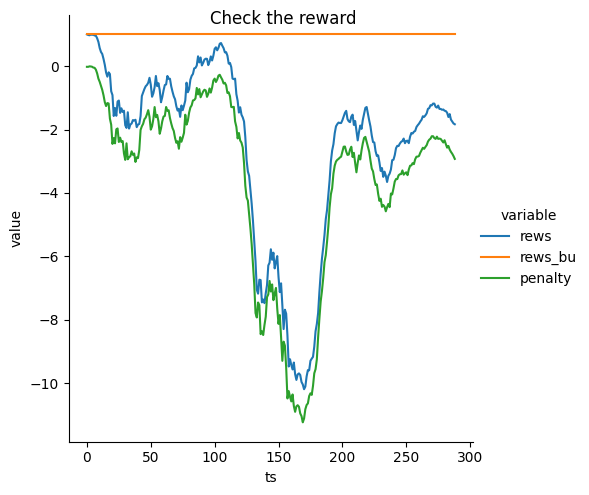

In [60]:
df = data_w.copy()
df["penalty"] = -agent.l2rpn_agent.gymenv.alpha*((df["storage_charge_norm_0"] - df["storage_setpoint_0"])**2 + (df["storage_charge_norm_1"] - df["storage_setpoint_1"])**2)/2
df = pd.melt(df, id_vars="ts", value_vars=["rews", "rews_bu", "penalty"])
g = sns.relplot(df, x="ts", y="value", hue="variable", kind="line")
g.fig.suptitle("Check the reward")


In [61]:
g = px.line(data, x = "ts", y = ["storage_charge_norm", "storage_setpoint"], facet_col="stor_id"
    # height=1000
    )
g.update_layout(yaxis_title='storage_capacity')
# g.add_hline(y=0, line_width=2, line_dash="dash", line_color="grey")
g.show()

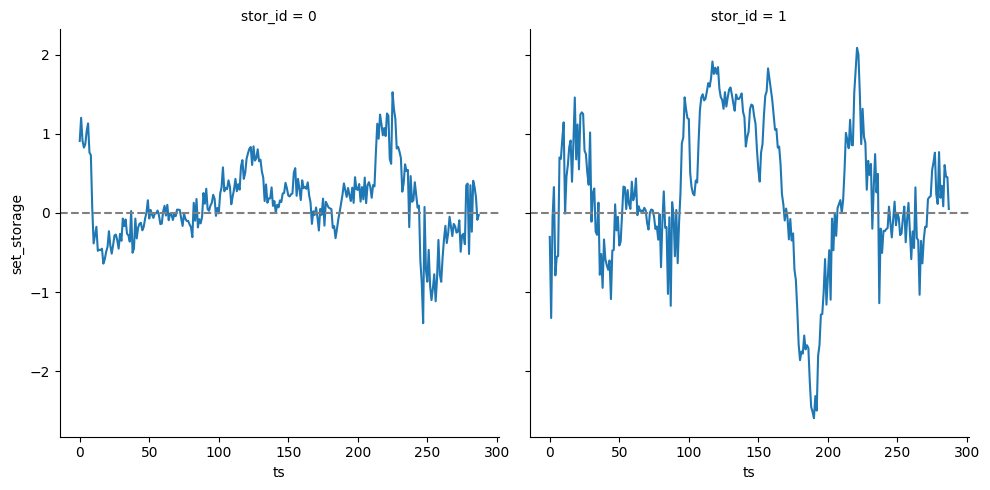

In [62]:
df = data.copy()
g = sns.relplot(data, x="ts", y="set_storage", col="stor_id", kind="line")
g.refline(y=0, ls = "--", color="grey")